# ResNet50

ResNet50 is a convolutional neural network that is 50 layers deep.

This notebook will train our ResNet50 model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/Shareddrives/Visual Information Processing/'

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras 
import random
from random import shuffle 
import collections
import io
import math

import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install Keras-Applications

In [6]:
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [7]:
FLOWERS_DIR = '/content/drive/Shareddrives/Visual Information Processing/FlowerData-30'

In [8]:
H, W = 224, 224
BATCH_SIZE = 64
EPOCHS = 100

TRAIN_FRACTION = 80
RANDOM_SEED = 2018

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1982 images belonging to 30 classes.
Found 491 images belonging to 30 classes.


## Building the Model 

We implemented transfer learning by loading a pretrained ResNet50 (weights learned from the public ImageNet database). Several dense layer was added to the end of the model to make it classify our 30 flower classes.

In [50]:
# IMG_SHAPE = (224,224) + (3,)
# preprocess_input = tf.keras.applications.resnet50.preprocess_input 

# base_model =tf.keras.applications.resnet50.ResNet50(
#                                 include_top=False,
#                                 weights="imagenet",
#                                 input_shape=IMG_SHAPE,
#                             )
# base_model = tf.keras.applications.InceptionV3(
#                                 include_top=False,
#                                 weights="imagenet",
#                                 input_shape=IMG_SHAPE,
#                             )

# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x, training=True)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# output = Dense(30, activation='softmax')(x)
# model = tf.keras.Model(inputs, output)
# model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_16  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_16 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0  

In [51]:
inputs = tf.keras.Input(shape=(224, 224, 3))
IMG_SHAPE = (224,224) + (3,)
x = tf.keras.applications.resnet50.ResNet50(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

for layer in x.layers:
	layer.trainable = False
    
flat1 = tf.keras.layers.GlobalAveragePooling2D()(x.layers[-1].output)
flat2 = tf.keras.layers.Dropout(0.2)(flat1)
class1 = Dense(1024, activation='relu')(flat2)
output = Dense(30, activation='softmax')(class1)
model = tf.keras.Model(inputs=x.inputs, outputs=output)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_38[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
# base_model = ResNet50(
#     input_shape=(H, W, 3), 
#     weights='imagenet',
#     include_top=False, 
#     pooling='avg',
# )

# base_model.trainable = False

# output_class = 30

# model = Sequential([
#     base_model,
#     Dense(1024, activation='relu'),
#     Dense(1024, activation='relu'),
#     Dense(512, activation='relu'),
#     Dense(30, activation='softmax')
# ])

# model.summary()

In [52]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [53]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(path + 'ResNet50_checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [54]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n / BATCH_SIZE, 
    validation_data = validation_generator,
    validation_steps = validation_generator.n / BATCH_SIZE,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
31/30 [==============================] - ETA: 0s - loss: 3.5713 - accuracy: 0.0414
Epoch 00001: val_loss improved from inf to 3.38993, saving model to /content/drive/Shareddrives/Visual Information Processing/ResNet50_checkpoint.h5
30/30 [==============================] - 52s 2s/step - loss: 3.5713 - accuracy: 0.0414 - val_loss: 3.3899 - val_accuracy: 0.0570 - lr: 0.0010
Epoch 2/100
31/30 [==============================] - ETA: 0s - loss: 3.3832 - accuracy: 0.0585
Epoch 00002: val_loss improved from 3.38993 to 3.32034, saving model to /content/drive/Shareddrives/Visual Information Processing/ResNet50_checkpoint.h5
30/30 [==============================] - 47s 2s/step - loss: 3.3832 - accuracy: 0.0585 - val_loss: 3.3203 - val_accuracy: 0.0468 - lr: 0.0010
Epoch 3/100
31/30 [==============================] - ETA: 0s - loss: 3.3110 - accuracy: 0.0621
Epoch 00003: val_loss improved from 3.32034 to 3.26267, saving model to /content/drive/Shareddrives/Visual Information Processing

## Evaluation

In [55]:
def plot_accuracy_loss(history):
    
    ### Plot the accuracy and the loss during the training of the nn.
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', 
             label = "Training Accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', 
             label = "Validation Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', 
             label = "Training Loss")
    plt.plot(history.history['val_loss'], 'ro--', 
             label = "Validation Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

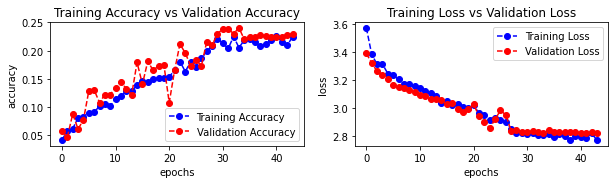

In [56]:
plot_accuracy_loss(history)

## Saving the Model

In [57]:
model.save(path +'ResNet50.h5')

In [58]:
model.save('ResNet50.h5')

In [60]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_38[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [87]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])

    with tf.GradientTape() as tape:
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
    grads = tape.gradient(loss, convOutputs)
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom

    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)
    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img_rgb

In [88]:
img.shape

(569, 500, 3)

In [96]:
import random
from random import shuffle 
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files
  
  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns 
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files


In [97]:
val_imgs = '/content/drive/Shareddrives/Visual Information Processing/FlowerData-30/Artichoke/'
class_info = {0: 'Artichoke', 1: 'Non-Artichoke'}

X, y, files = manual_pre_process(val_imgs, 224)

100%|██████████| 78/78 [00:00<00:00, 98.68it/s]


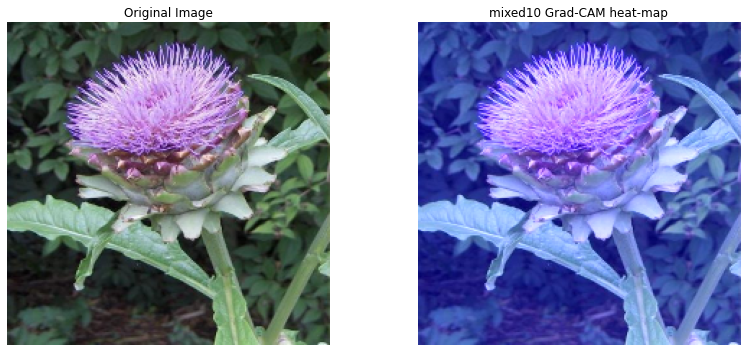

In [145]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1
import cv2

layer_name = 'conv5_block3_out'
img = cv2.imread('/content/drive/Shareddrives/Visual Information Processing/FlowerData-30/Artichoke/image_04081.jpg')
img = cv2.resize(img, (224,224))
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('mixed10 Grad-CAM heat-map')
plt.tight_layout()

In [164]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]

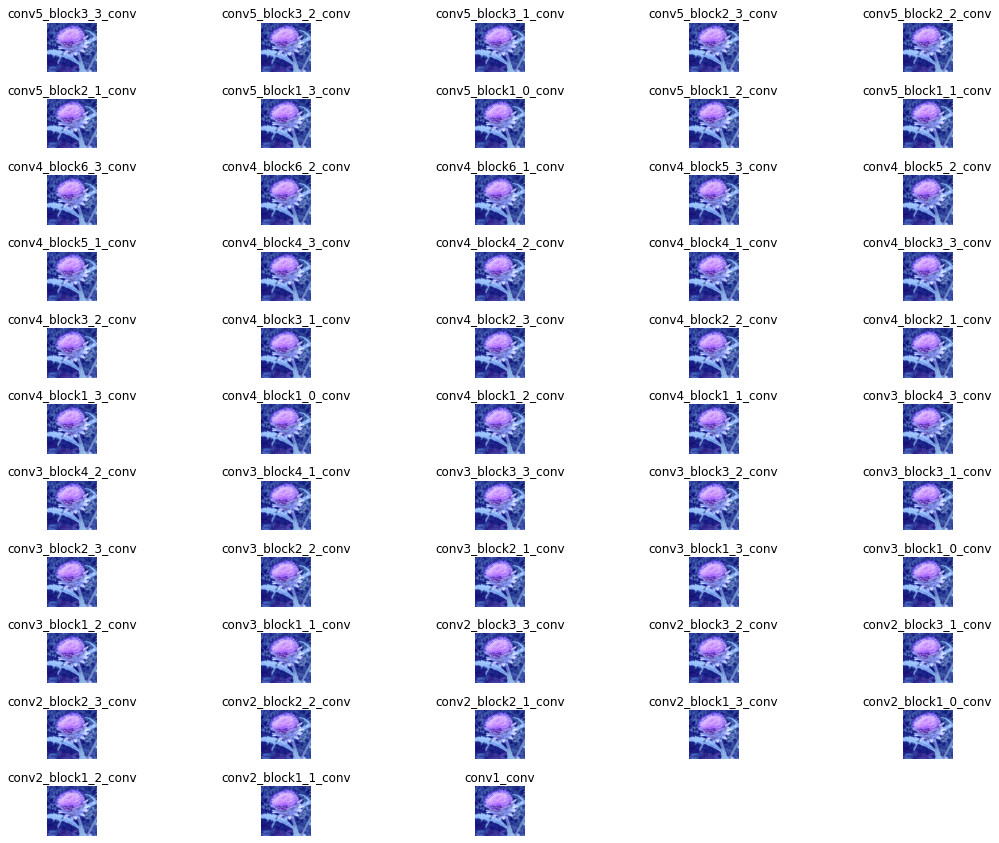

In [165]:
plt.figure(figsize=(15, 15))
for i, layer in enumerate(conv2D_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(14, 5, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

In [160]:
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(14, 5, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

<Figure size 1080x1080 with 0 Axes>